In [64]:
from ipywidgets import *
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import root

%matplotlib widget

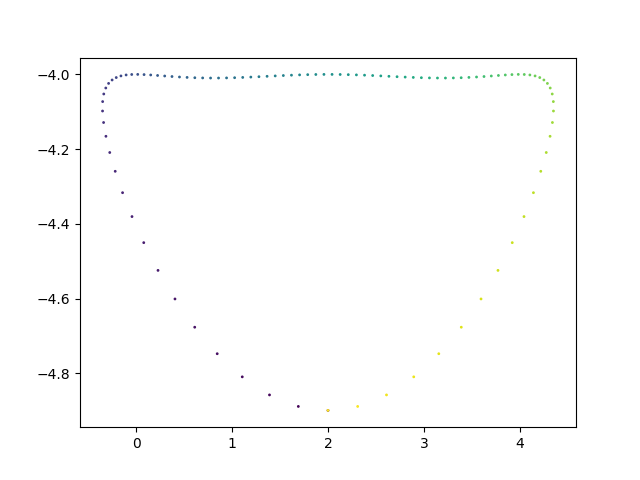

In [97]:
theta1_range = np.linspace(0, 2*pi, 100)
trace = []
guess = np.zeros(4)

L1, L2, L3, L4, L5, theta5 = (1, 2.5, 2.5, 2, 2.5, radians(0))
sin5 = sin(theta5)
cos5 = cos(theta5)

for theta1 in theta1_range:
    sin1 = sin(theta1)
    cos1 = cos(theta1)
    def func_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            L1*sin1 + L2*sin2 + L3*sin3,
            L1*cos1 + L2*cos2 + L3*cos3 - L4, 
            sin2**2 + cos2**2 - 1,
            sin3**2 + cos3**2 - 1,        
        ]
    def jac_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            [L2, 0, L3, 0],
            [0, L2, 0, L3],
            [2*sin2, 2*cos2, 0, 0],
            [0, 0, 2*sin3, 2*cos3]
        ]
    
    sol = root(func_sincos, jac=jac_sincos, x0=guess, method='hybr').x
    sin2, cos2, sin3, cos3 = sol
    guess = sol

    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])
    trace.append(p5)

trace = np.array(trace)

plt.figure()
plt.scatter(trace[:,0], trace[:,1], c=theta1_range, s=1)
plt.show()

In [ ]:

# def loop_eqs(thetas):

#     [theta1, theta2, theta3, theta4, theta5] = thetas

#     return [
#         L1*cos(thetaX) + L3*cos(theta3) - L1*cos(theta1),
#         Lx*sin(thetaX) + L3*sin(theta3) - L1*sin(theta1),

#         L4*cos(theta4) + L5*cos(theta5) - L6*cos(theta6) - L2*cos(theta2) + L8*cos(theta8),
#         L4*sin(theta4) + L5*sin(theta5) - L6*sin(theta6) - L2*sin(theta2) + L8*sin(theta8),

#         L5*cos(theta5) + L8*cos(theta8) + L9*cos(theta9) - L7*cos(theta7) - L10*cos(theta10),
#         L5*sin(theta5) + L8*sin(theta8) + L9*sin(theta9) - L7*sin(theta7) - L10*sin(theta10),
        
#         theta4 - theta3 - thetaA,
#         theta5 - theta4 + thetaB,
#         theta9 - theta8 + thetaC,
#         theta11 - theta10 - thetaD
#     ]

# root, infodict, ier, msg = fsolve(loop_eqs, guess, full_output=1)

